<a href="https://colab.research.google.com/github/hg1722/fashionista/blob/master/datasets/deepfashion/image_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
import cv2
import os

In [0]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.4.2-cp36-none-any.whl size=14848 sha256=d1373bcd79157d7e1b34f125e1785b1c143d03dc401751a599b19d050b429efc
  Stored in directory: /root/.cache/pip/wheels/20/60/80/ac3137e38826728a2857a536aa306f7d92ba019264e5afb803
Successfully built pandarallel


In [0]:
path = "/content/drive/My Drive/fashion/"
n_samples = 2000

In [0]:
data = pd.read_pickle(path+"data.pkl")
landmarks = pd.read_pickle(path+"landmarks.pkl")
bbox = pd.read_pickle(path+"bbox.pkl")
data[5] += 435

In [0]:
!unzip -q "/content/drive/My Drive/img.zip" -d "/tmp"

In [0]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/fashion/img_highres.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [0]:
filenames = []
for r, d, files in os.walk("/tmp/img_highres"):
    fn = r.replace("/tmp/img_highres", "img")
    for f in files:
        if f.endswith(".jpg"):
            filenames.append(fn + "/" + f)
len(filenames)

289212

In [0]:
data.img.unique().shape

(289222,)

In [0]:
data_t = data[landmarks.clothes_type != 3].dropna(axis=0, thresh=3)[:n_samples].fillna(-1)

In [0]:
lens = {i: int(data_t[i].str.len().max()) for i in range(1,5)}

In [0]:
def f(r):
    v = []
    for i in range(1,5):
        if r[i] == -1:
            v.extend([-1] * lens[i])
        else:
            v.extend(r[i] + [-1] * (lens[i] - len(r[i])))
    v.append(r[5])
    return pd.Series(v, dtype=int)
data_np = data_t.apply(f, axis=1)

In [0]:
embeddings = data_np.values.reshape((2000, 20))

In [0]:
np.save('/content/drive/My Drive/fashion/train/embeddings', embeddings)
np.save('/content/drive/My Drive/fashion/test/embeddings', embeddings)

In [0]:
filenames = data_t.img.to_list()

In [0]:
with open('/content/drive/My Drive/fashion/train/filenames.pickle', 'wb') as f:
    pkl.dump(filenames, f)

with open('/content/drive/My Drive/fashion/test/filenames.pickle', 'wb') as f:
    pkl.dump(filenames, f)

In [0]:

# Display one image
def display(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()

In [0]:
def jumpcut(frame, bbox):
    mask = np.zeros(frame.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = bbox
    cv2.grabCut(frame,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0),0,255).astype('uint8')
    frame[mask2 != 255] = [255, 255, 255]
    # img = img*mask2[:,:,np.newaxis]

In [0]:
def jumpcut_mask(frame, mask):
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    mask, bgdModel, fgdModel = cv2.grabCut(frame,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
    display(mask)
    mask2 = np.where((mask==2)|(mask==0),0,255).astype('uint8')
    frame[mask2 != 255] = [255, 255, 255]
    # img = img*mask2[:,:,np.newaxis]

In [0]:
def jumpcut_mask2(frame, bbox, mask_new):
    mask = np.zeros(frame.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1])
    cv2.grabCut(frame,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

    mask[mask_new == 1] = 1

    mask, bgdModel, fgdModel = cv2.grabCut(frame,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
    mask2 = np.where((mask==2)|(mask==0),0,255).astype('uint8')
    frame[mask2 != 255] = [255, 255, 255]
    # img = img*mask2[:,:,np.newaxis]

In [0]:
def watershed(frame):
    no_noise = cv2.GaussianBlur(frame, (5, 5), 0)
    gray = cv2.cvtColor(no_noise, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv2.watershed(frame, markers)

    frame[markers == 1] = [255, 255, 255]
    return frame

In [0]:
from itertools import product
lm_dict = {2: ["landmark_location_{}_{}".format(c, str(i)) for i, c in product(range(1,5), ["x", "y"])],
1: ["landmark_location_{}_{}".format(c, str(i)) for i, c in product(range(1,7), ["x", "y"])],
3: ["landmark_location_{}_{}".format(c, str(i)) for i, c in product(range(1,9), ["x", "y"])]}

In [0]:
def image_resize(image, inter = cv2.INTER_LINEAR, dim = None):
    if dim is not None:
        return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
      
    dim = None
    (h, w) = image.shape[:2]
    if h > w:
        r = 300 / float(h)
        dim = (int(w * r), 300)
    else:
        r = 300 / float(w)
        dim = (300, int(h * r))

    resized = cv2.resize(image, dim, interpolation = cv2.INTER_LINEAR)
    return resized


In [0]:
def get_landmarks(f, shape_):
    feature_mask = np.zeros(shape_, dtype=np.uint8)
    landmark_type = lm_dict[f.clothes_type]
    shape = f[landmark_type].values.reshape(1,len(landmark_type)//2,2).astype(np.int32)
    shape = cv2.convexHull(shape)
    cv2.fillConvexPoly(feature_mask, shape, 1)
    return feature_mask

In [0]:
image_data = landmarks[landmarks.image_name.isin(filenames)].merge(bbox[bbox.image_name.isin(filenames)], on="image_name")

In [0]:
sizes = [
    4,
    8,
    16,
    32,
    64,
    128,
    256
]

def processing(data):
    
    a = []
    for row in data.itertuples():
        i = row.image_name
        img1 = image_resize(cv2.imread("/tmp/img_highres/" + i[4:], cv2.IMREAD_UNCHANGED))
        img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        box = [row.x_1, row.y_1, row.x_2, row.y_2]
        jumpcut_mask2(img, tuple(box), get_landmarks(row, img.shape[:2]))
        imgt = img[box[1]:box[3], box[0]:box[2]]
        a.append(image_resize(imgt, dim=(256, 256)))

    imgs = np.array(a)
    return imgs

In [0]:
def processing(row):

    i = row.image_name
    img1 = image_resize(cv2.imread("/tmp/img_highres/" + i[4:], cv2.IMREAD_UNCHANGED))
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    box = [row.x_1, row.y_1, row.x_2, row.y_2]
    jumpcut_mask2(img, tuple(box), get_landmarks(row, img.shape[:2]))
    imgt = img[box[1]:box[3], box[0]:box[2]]
    a = image_resize(imgt, dim=(256, 256))
    return a

In [0]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=8)
images = image_data.parallel_apply(processing, axis=1)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
   0.00%                                          |        0 /      250 |      
   0.00%                                          |        0 /      250 |      
   0.00%                                          |        0 /      250 |      
   0.00%                                          |        0 /      250 |      
   0.00%                                          |        0 /      250 |      
   0.00%                                          |        0 /      250 |      
   0.00%                                          |        0 /      250 |      
   0.00%                                          |        0 /      250 |      MMMMMMM   0.00%                                          |        0 /      250 |      
   0.00%                                      

In [0]:
images_256 = np.c_[images.to_list()] / 255.0

In [0]:
img_standard = (images_256 - images_256.mean(axis=(0,1,2)))/images_256.std(axis=(0,1,2))
# img_standard
# for i in img_standard:
#     display(i)

In [0]:

np.save('/content/drive/My Drive/fashion/train/256images', images_256)
np.save('/content/drive/My Drive/fashion/test/256images', images_256)

In [0]:
images_256 = np.load('/content/drive/My Drive/fashion/train/256images.npy')

In [0]:
images_256 = np.c_[images_256.tolist()]

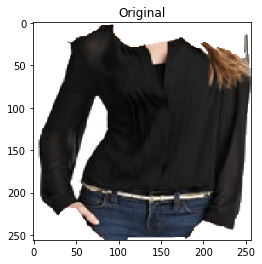

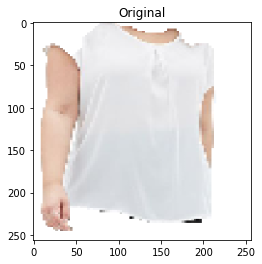

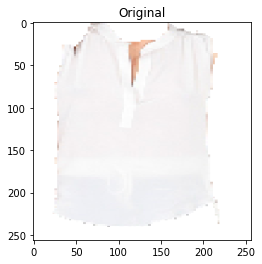

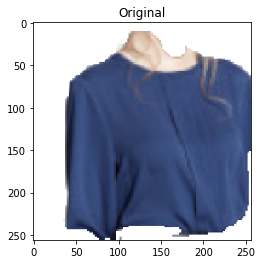

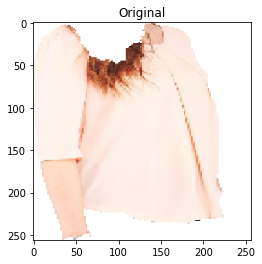

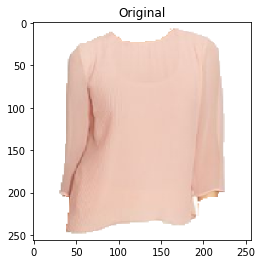

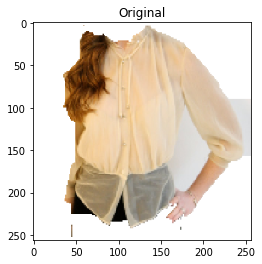

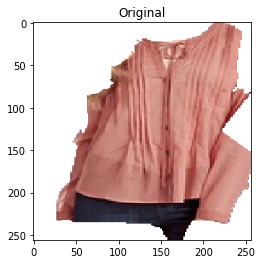

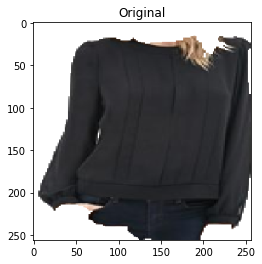

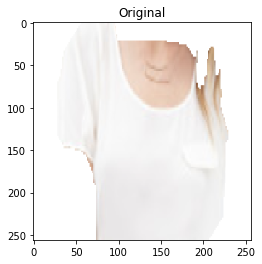

In [0]:
images_256 = images_256 / 255.0
for i in images_256[:10]:
    display(i)

In [0]:
sizes = [
    4,
    8,
    16,
    32,
    64,
    128
]
for s in reversed(sizes):
    imgs = np.c_[[image_resize(i, dim=(s,s)) for i in images_256]]
    np.save('/content/drive/My Drive/fashion/train/{}images'.format(int(s)), imgs)
    np.save('/content/drive/My Drive/fashion/test/{}images'.format(int(s)), imgs)
    del imgs

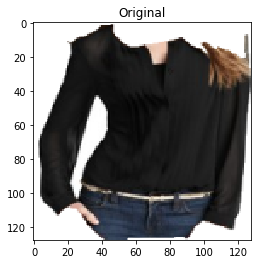

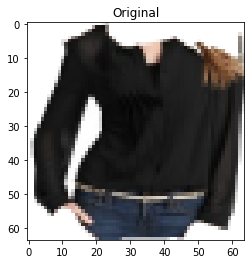

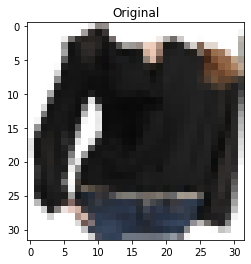

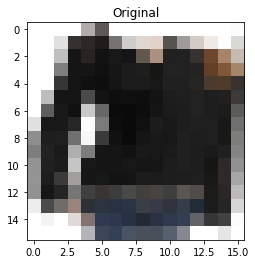

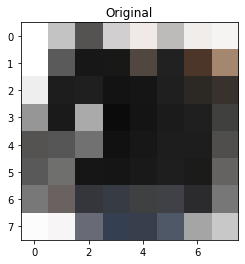

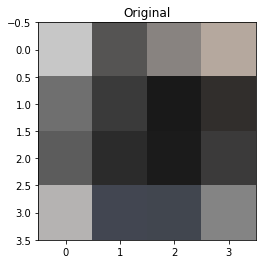

In [0]:
for s in reversed(sizes):
    v = np.load('/content/drive/My Drive/fashion/test/{}images.npy'.format(int(s)))
    display(v[0])